# SENTIMENT ANALYSIS



In [15]:
#Release: 1.2010.0901

# Library

For this lab, we will need ``wordcloud`` library.
Use pip to install the library from Anaconda prompt : ``pip install wordcloud``.

In [16]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split 

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

from subprocess import check_output

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Data

In [17]:
!mkdir -p dataset
!wget https://raw.githubusercontent.com/project303/dataset/master/Twitter.csv -P dataset

--2020-11-28 03:15:24--  https://raw.githubusercontent.com/project303/dataset/master/Twitter.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 413468 (404K) [text/plain]
Saving to: ‘dataset/Twitter.csv.1’

Twitter.csv.1       100%[===================>] 403.78K  --.-KB/s    in 0.03s   

2020-11-28 03:15:24 (14.8 MB/s) - ‘dataset/Twitter.csv.1’ saved [413468/413468]



In [18]:
!ls dataset

Twitter.csv  Twitter.csv.1


In [19]:
data = pd.read_csv('dataset/Twitter.csv', sep='|')
# Choose the column we will be using
data = data[['text','sentiment']]
len(data)

4294

In [20]:
data[:10]

,text,sentiment
0,@IndosatCare iya nomernya masih itu. Mksh.,Positif
1,@IndosatCare udah di DM yah,Positif
2,@Telkomsel aku pakai loop kak :),Positif
3,@rikawidjaya04 Terima kasih juga Kak Rika atas...,Positif
4,@ndusell saya simpati tan,Positif
5,@telkomsel terima kasih penjelasannya mimin,Positif
6,"@indosatcare terima kasih ya, untuk informasinya.",Positif
7,@Telkomsel yess yess,Positif
8,@Telkomsel ok thanks,Positif
9,thanks @IndosatCare koneksi internet sudah nor...,Positif


In [21]:
# Bagi dataset menjadi data training dan testing
train, test = train_test_split(data,test_size = 0.2)
# Hapus sentiment yang netral
train = train[train.sentiment != "Neutral"]

train_pos = train[ train['sentiment'] == 'Positif']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negatif']
train_neg = train_neg['text']

In [22]:
train_pos

3890          Presiden Jokowi: Selamat Hari Pramuka Ke55
4204        Kemhan Targetkan Empat Juta Kader Bela Negara
3849              Menhan Pimpin Apel Bela Negara di Monas
3073    Pangkalan Militer Di Natuna Akan Dibangun TNI ...
3175    Pengendalian Senjata Api Non Organik Kepolisia...
                              ...                        
4180    Panglima TNI Hadiri Apel Gelar Nasional Bela N...
2832    Gubernur Bali setuju ormas ikut bela negara bi...
4284    President hails strategic partnership with Ind...
3442          Imparsial   Kemenhan Ambil Alih BAIS Saja  
3529    Nasional   Pembentukan Badan Intelijen Pertaha...
Name: text, Length: 1067, dtype: object

In [23]:
train_neg

1408    @IndosatCare saya sudah registrasi paket extra...
1118    @Telkomsel udah direstart min msh gabisa terus...
2022    Bela Negara Antara Membela Negara Sendiri dan ...
2148    Menteri disuruh hemat anggaran malah minta ini...
1191    @Telkomsel sinyalnya knapa ya?ilang ilang trs....
                              ...                        
1134    Td sore saya beli paket internet Im3 tp sampai...
973     @indosatcare sinyal hsdpa kadang2 ilang,,masa ...
3642            11.000 Tentara Filipina Kepung Abu Sayyaf
1612    @Telkomsel semua udah min, mulai dr restart, s...
3571    Pembaruan Alutsista Tertunda Pemangkasan Anggaran
Name: text, Length: 1023, dtype: object

In [24]:
#augment the stopwords with nonstandard twitter words
stopwords_set = set(stopwords.words("indonesian"))
stopwords_aug = {"ya","yak","iya","yg","ga","gak","gk","udh","sdh","udah","dah","nih","ini","deh","sih","dong","donk",
                 "sm","knp","utk","yaa","tdk","gini","gitu","bgt","gt","nya","kalo","cb","jg","jgn","gw","ge",
                 "sy","min","mas","mba","mbak","pak","kak","trus","trs","bs","bisa","aja","saja","no",
                 "w","g","gua","gue","emang","emg","wkwk","dr","kau","dg","gimana","apapun","apa",
                 "klo","yah","banget","pake","terus","krn","jadi","jd","mu","ku","si","hehe",
                 "tp","pa","lu","lo","lw","tw","tau","karna","kayak","ky","lg","untuk","tuk","dg","dgn"}
stopwords_all = stopwords_set.union(stopwords_aug)

In [25]:
#stopwords_set

Positive words


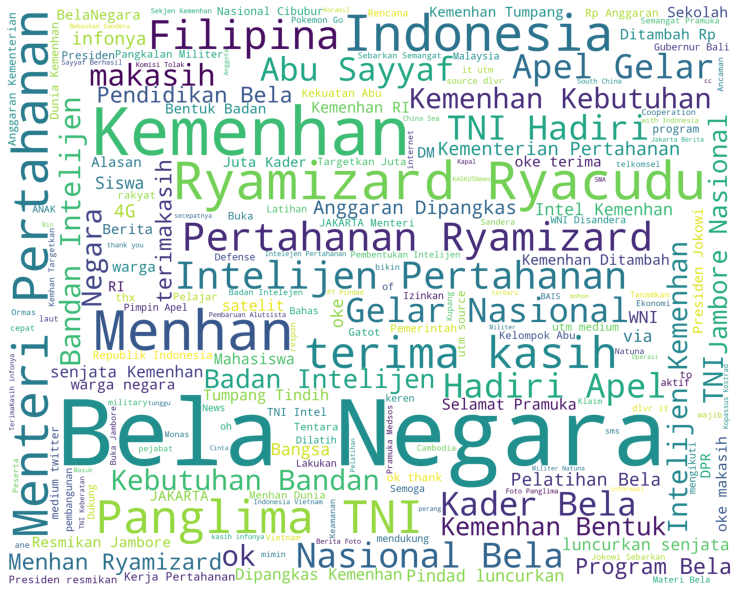

Negative words


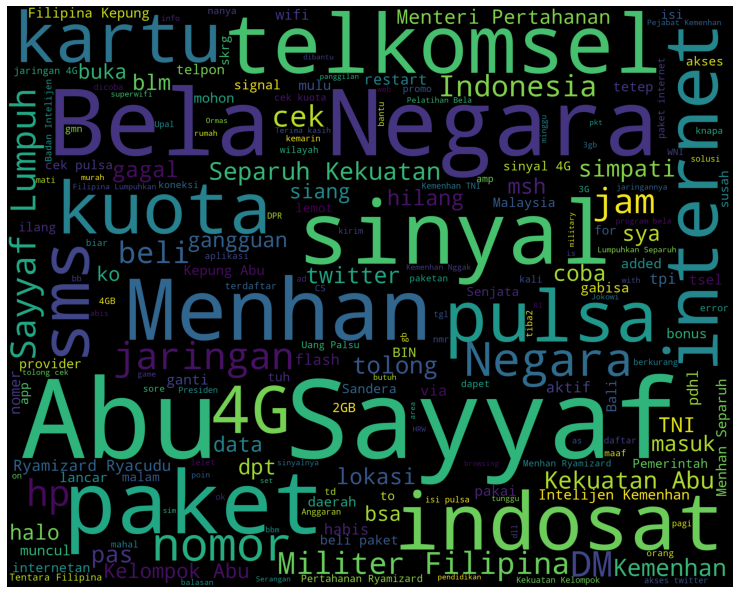

In [26]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=stopwords_all,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [27]:
tweets = []
#stopwords_set = set(stopwords.words("indonesia"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_all]
    tweets.append((words_cleaned,row.sentiment))

test_pos = test[ test['sentiment'] == 'Positif']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negatif']
test_neg = test_neg['text']

In [28]:
test_pos

2880    Merasa ga mampu berbuat besar inovasi bela neg...
2999      Paradoks Intelijen Kemenhan by Soleman B Ponto 
1714                 @Telkomsel oke saya tunggu hasilnya.
2912    Menteri Pertahanan Ryamizard Ryacudu mengataka...
2762    Sebelum KKN di Poso Mahasiswa Unhas Ikut Pendi...
                              ...                        
3189    Indonesia seharusnya mengadakan program bela n...
3309    Kapolres Majene Beri Paparan tentang Bela Nega...
3426    Udah ada yg bisa ngebayangin seperti apa nanti...
3531    Penjelasan Pentingnya Kemenhan Punya Badan Int...
2841    Pelatihan Bela Negara Digalakkan untuk Lawan A...
Name: text, Length: 278, dtype: object

In [29]:
test_neg

3643    Ryamizard: Bebaskan 10 WNI, Duterte Pimpin Ser...
2046    Berita Indonesia Menhan satelit militer harus ...
1223    @Telkomsel Siang telkomsel kenapa saya coba be...
974     Isi pulsa @Telkomsel 4 hari ga masuk masuk. Ga...
1151    @IndosatCare Halah.. Percuma ajalah lapor. Gak...
                              ...                        
1519    @Telkomsel semua no telkomsel. 6 nomor telkoms...
1394                  @Telkomsel emang yg ini kenapa min?
2174    Samaji Worker Abdul Sattar Edhi Ke Intqal Per ...
1270    @Telkomsel oh begitu jadi pada intinya sedang ...
2020    BELA negara semacam jadi program perekrutan an...
Name: text, Length: 248, dtype: object

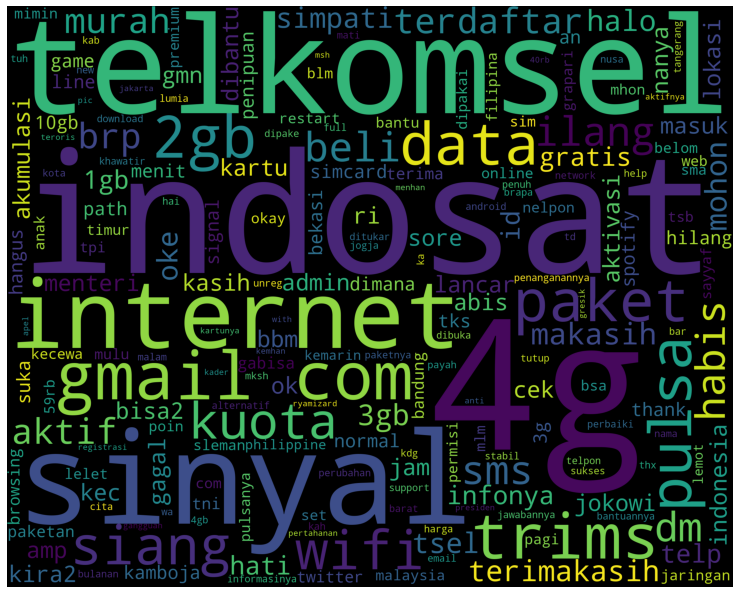

[Negatif]: 248/116 
[Positif]: 278/112 


In [30]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))


def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features


wordcloud_draw(w_features)

# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negatif'): 
        neg_cnt = neg_cnt + 1
        #print(obj.split())
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positif'): 
        pos_cnt = pos_cnt + 1
        
print('[Negatif]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positif]: %s/%s '  % (len(test_pos),pos_cnt))


In [31]:

print("Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, training_set))*100)

Naive Bayes Algo accuracy percent: 86.8122270742358


In [32]:
tweets_test = []
#stopwords_set = set(stopwords.words("indonesia"))

for index, row in test.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_all]
    tweets_test.append((words_cleaned,row.sentiment))

test_set = nltk.classify.apply_features(extract_features,tweets_test)

In [33]:
print("Naive Bayes Algo accuracy on test percent:", (nltk.classify.accuracy(classifier, test_set))*100)

Naive Bayes Algo accuracy on test percent: 71.82770663562282


In [34]:
w_features

dict_keys(['presiden', 'jokowi:', 'selamat', 'hari', 'pramuka', 'ke\x9655', 'saya', 'sudah', 'registrasi', 'paket', 'extra', '40rb,', 'tetapi', 'cek', 'kuota', 'tidak', 'terdaftar.', 'sehingga', 'pulsa', 'masuk', 'tapi', 'ada', 'paket.', 'kemhan', 'targetkan', 'empat', 'juta', 'kader', 'bela', 'negara', 'latih', 'ajudan', 'menteri', 'jadi', 'intelijen', 'anti\x96teroris', 'udah', 'direstart', 'min', 'msh', 'gabisa', 'terus', 'masih', 'sama', 'antara', 'membela', 'sendiri', 'dan', 'kepentingan', 'asing', 'disuruh', 'hemat', 'anggaran', 'malah', 'minta', 'ini', 'itu', 'capek', 'deh', 'wapres', 'kalla', 'anggap', 'kemenhan', 'belum', 'butuh', 'lembaga', 'alumni', 'jas', 'dodik', 'belanegara', 'with', 'gita', 'ahmad', 'nizar', 'and', 'others', 'sor', 'tri', 'dharma', 'petrokimia', 'gresik', 'pic', 'sinyalnya', 'knapa', 'ya?ilang', 'ilang', 'trs..apa', 'gangguan?', 'menhan', 'pimpin', 'apel', 'monas', 'perwira', 'tni', 'pembawa', 'upal', 'ternyata', 'pejabat', 'kemenhanperwiratnipengedarupa

In [35]:
nltk.FreqDist(get_words_in_tweets(tweets))

FreqDist({'presiden': 50,
          'jokowi:': 14,
          'selamat': 38,
          'hari': 71,
          'pramuka': 28,
          'ke\x9655': 2,
          'saya': 376,
          'sudah': 158,
          'registrasi': 12,
          'paket': 211,
          'extra': 7,
          '40rb,': 1,
          'tetapi': 4,
          'cek': 94,
          'kuota': 85,
          'tidak': 106,
          'terdaftar.': 1,
          'sehingga': 1,
          'pulsa': 101,
          'masuk': 35,
          'tapi': 80,
          'ada': 293,
          'paket.': 2,
          'kemhan': 19,
          'targetkan': 8,
          'empat': 30,
          'juta': 24,
          'kader': 44,
          'bela': 579,
          'negara': 646,
          'latih': 10,
          'ajudan': 2,
          'menteri': 127,
          'jadi': 87,
          'intelijen': 207,
          'anti\x96teroris': 2,
          'udah': 109,
          'direstart': 3,
          'min': 188,
          'msh': 26,
          'gabisa': 14,
          'terus

In [36]:
tweets

[(['presiden', 'jokowi:', 'selamat', 'hari', 'pramuka', 'ke\x9655'],
  'Positif'),
 (['saya',
   'sudah',
   'registrasi',
   'paket',
   'extra',
   '40rb,',
   'tetapi',
   'cek',
   'kuota',
   'tidak',
   'terdaftar.',
   'sehingga',
   'pulsa',
   'masuk',
   'tapi',
   'tidak',
   'ada',
   'paket.'],
  'Negatif'),
 (['kemhan', 'targetkan', 'empat', 'juta', 'kader', 'bela', 'negara'],
  'Positif'),
 (['kemhan',
   'latih',
   'ajudan',
   'menteri',
   'jadi',
   'intelijen',
   'anti\x96teroris'],
  'Netral'),
 (['udah', 'direstart', 'min', 'msh', 'gabisa', 'terus', 'masih', 'sama'],
  'Negatif'),
 (['bela',
   'negara',
   'antara',
   'membela',
   'negara',
   'sendiri',
   'dan',
   'kepentingan',
   'negara',
   'negara',
   'asing'],
  'Negatif'),
 (['menteri',
   'disuruh',
   'hemat',
   'anggaran',
   'malah',
   'minta',
   'ini',
   'itu',
   'capek',
   'deh',
   'wapres',
   'kalla',
   'anggap',
   'kemenhan',
   'belum',
   'butuh',
   'lembaga',
   'intelijen'],


In [37]:
res =  classifier.classify(extract_features(['oke', 'nasional', 'banget']))
res

'Positif'

In [38]:
classifier.show_most_informative_features(15)

Most Informative Features
         containts(apel) = True           Positi : Netral =     39.9 : 1.0
        containts(paket) = True           Negati : Positi =     34.4 : 1.0
       containts(sinyal) = True           Negati : Netral =     30.8 : 1.0
     containts(jaringan) = True           Negati : Positi =     26.1 : 1.0
        containts(nomor) = True           Negati : Positi =     19.8 : 1.0
          containts(oke) = True           Positi : Negati =     16.9 : 1.0
      containts(makasih) = True           Positi : Netral =     16.9 : 1.0
     containts(nasional) = True           Positi : Negati =     16.8 : 1.0
       containts(hadiri) = True           Positi : Netral =     16.4 : 1.0
        containts(tetep) = True           Negati : Netral =     16.2 : 1.0
     containts(panglima) = True           Positi : Negati =     16.0 : 1.0
          containts(ya?) = True           Negati : Positi =     15.6 : 1.0
          containts(apa) = True           Netral : Positi =     14.8 : 1.0

In [39]:
#To save the trained claassifier, do the following
import pickle
f = open('my_classifier.pickle', 'wb')
pickle.dump(classifier, f)
f.close()

In [40]:
#To reload it:
f = open('my_classifier.pickle', 'rb')
classifier = pickle.load(f)
f.close()

In [41]:
pred = classifier.classify(extract_features(['makasih', 'sinyal', 'banget']))
pred

'Negatif'